[*********************100%%**********************]  1 of 1 completed


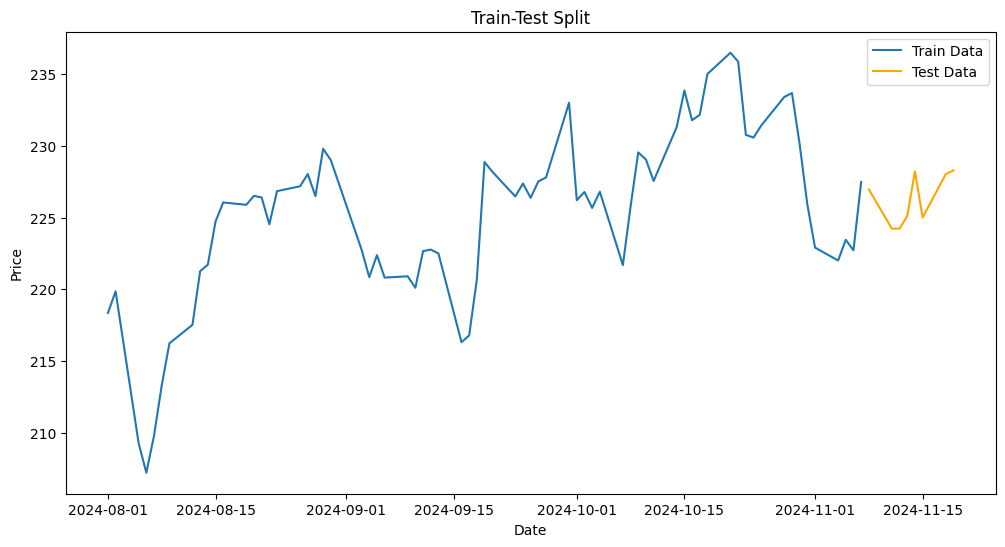

Applying exponential smoothing to the trend...
Exponential Smoothing Parameters:
Alpha (Level): 0.5, Beta (Trend): 0, Gamma (Seasonality): 0


/Users/owner/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/gv/mxw7p1nn5_b2n6n_7wkjz2sw0000gn/T/ipykernel_11672/4156310572.py:47: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  smoothed_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma, optimized=False)


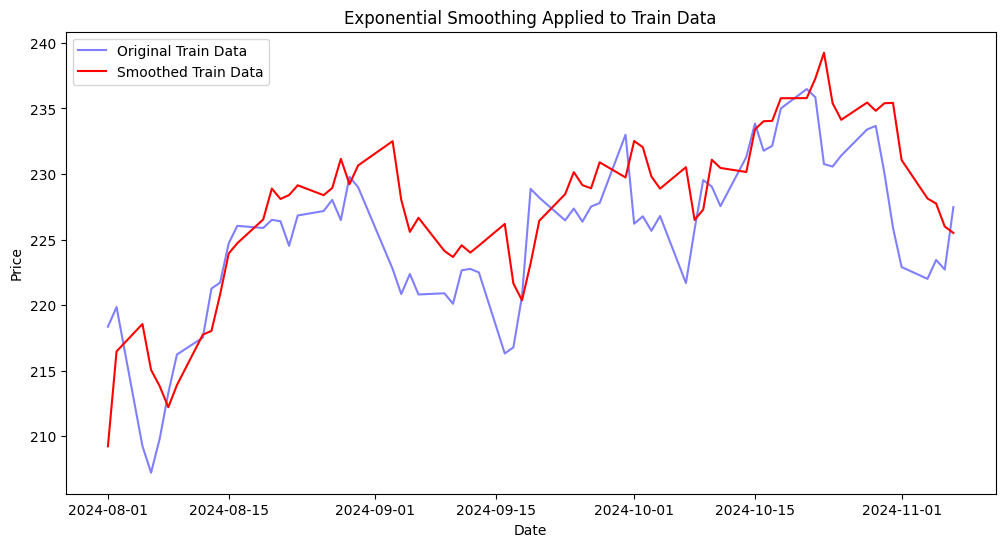

Data is non-stationary (p-value = 0.18252). Differencing applied.
Data is non-stationary (p-value = 0.09948). Differencing applied.
Data is stationary after 2 differencing step(s) (p-value = 0.00380).


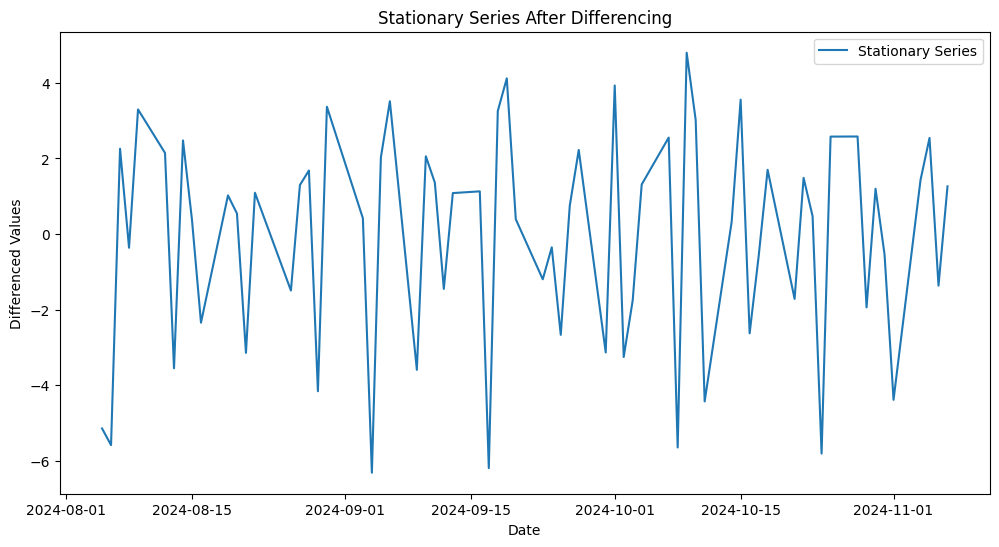

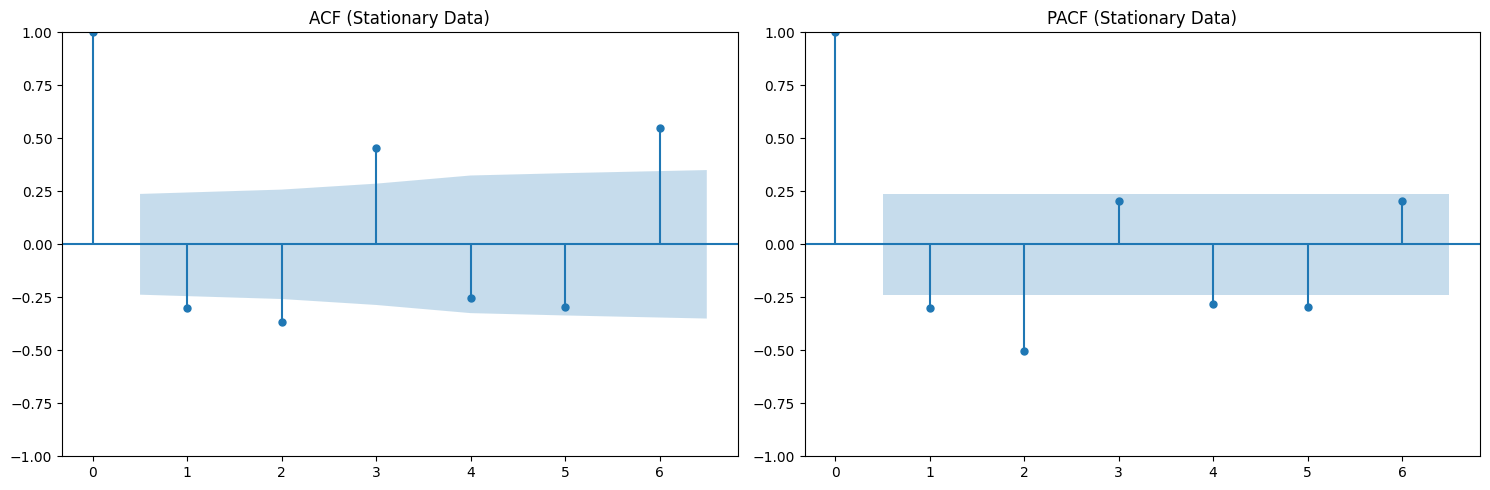

/Users/owner/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/owner/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                   70
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 3)   Log Likelihood                -104.269
Date:                                Fri, 29 Nov 2024   AIC                            220.537
Time:                                        14:29:27   BIC                            232.900
Sample:                                             0   HQIC                           225.353
                                                 - 70                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2821      0.357      0.790      0.430      -0.418       0.982
ma.

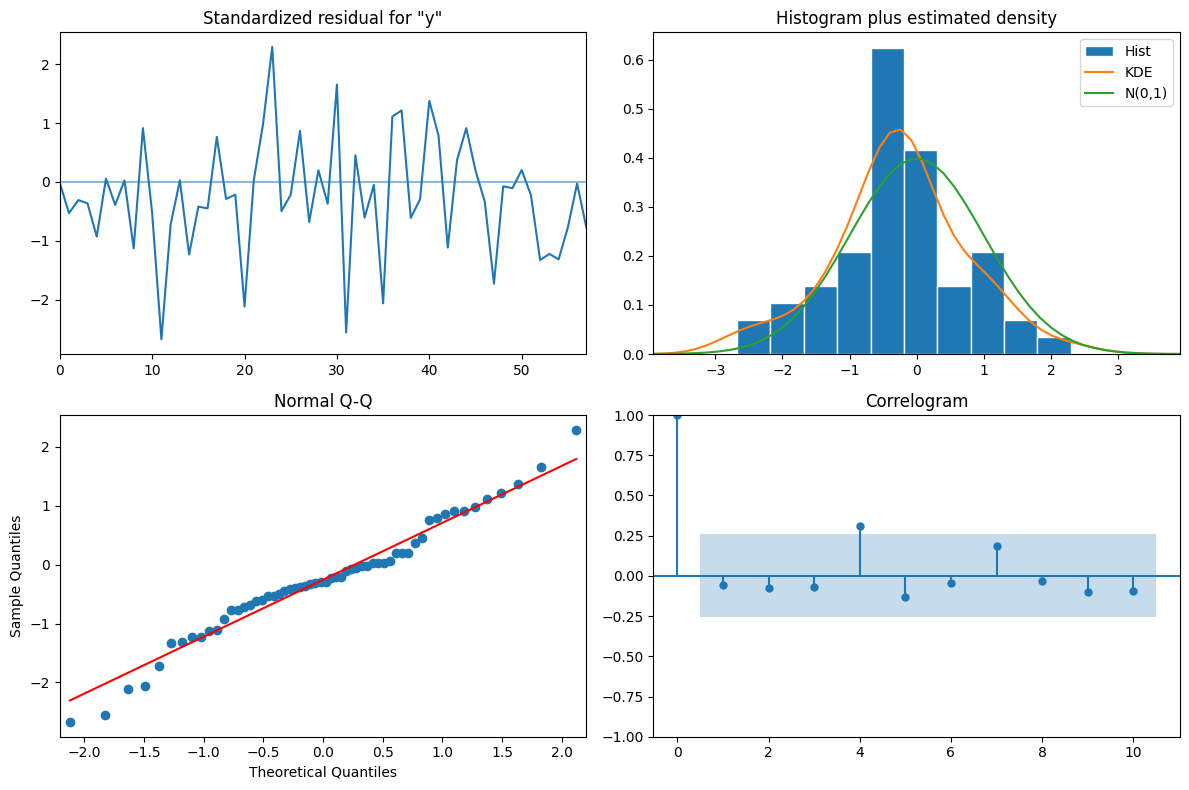

Ljung-Box Test Results:
     lb_stat  lb_pvalue
10  10.10785   0.431083


/Users/owner/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/owner/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


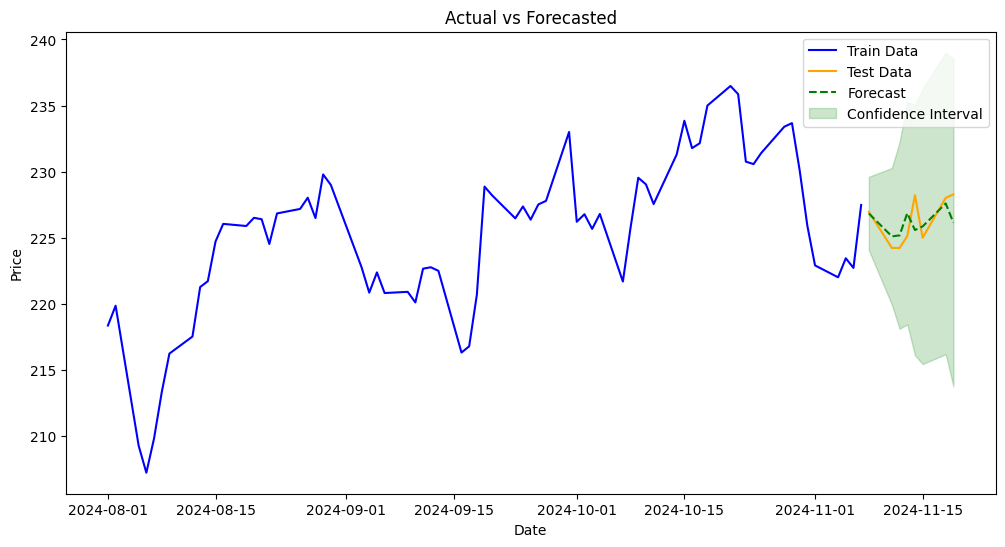

RMSE on Test Data: 1.4621220810578681


In [269]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import numpy as np

# Step 1: Fetch Apple stock data
apple_data = yf.download("AAPL", start="2024-08-01", end="2024-11-20")
apple_close = apple_data["Close"]

# Step 2: Train-Test Split
train_size = int(len(apple_close) * 0.90)
train, test = apple_close[:train_size], apple_close[train_size:]

# Plot train and test sets
plt.figure(figsize=(12, 6))
plt.plot(train, label="Train Data")
plt.plot(test, label="Test Data", color="orange")
plt.title("Train-Test Split")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Step 3: Option to Apply Exponential Smoothing with Custom Parameters
use_smoothing = True  # Set to True to apply exponential smoothing

# Set custom parameters for Exponential Smoothing
alpha = .5  # Smoothing level (overall data)
beta = 0   # Smoothing for the trend
gamma = 0  # Smoothing for seasonality (set None if no seasonality)

if use_smoothing:
    print("Applying exponential smoothing to the trend...")
    model = ExponentialSmoothing(
        train, 
        trend="add", 
        seasonal="add",  
        seasonal_periods=3
    )
    smoothed_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma, optimized=False)
    smoothed_train = smoothed_fit.fittedvalues
    print("Exponential Smoothing Parameters:")
    print(f"Alpha (Level): {alpha}, Beta (Trend): {beta}, Gamma (Seasonality): {gamma}")
else:
    smoothed_train = train

# Plot smoothed data (if applicable)
if use_smoothing:
    plt.figure(figsize=(12, 6))
    plt.plot(train, label="Original Train Data", color="blue", alpha=0.5)
    plt.plot(smoothed_train, label="Smoothed Train Data", color="red")
    plt.title("Exponential Smoothing Applied to Train Data")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Step 4: Augmented Dickey-Fuller Test with Iterative Differencing
def adf_test(series):
    """Perform Augmented Dickey-Fuller test."""
    result = adfuller(series)
    return result[1]  # Return p-value

# Check stationarity and difference iteratively
differenced_train = smoothed_train.copy()
d = 0
while adf_test(differenced_train) > 0.05:  # p-value > 0.05 means non-stationary
    print(f"Data is non-stationary (p-value = {adf_test(differenced_train):.5f}). Differencing applied.")
    differenced_train = differenced_train.diff().dropna()
    d += 1

print(f"Data is stationary after {d} differencing step(s) (p-value = {adf_test(differenced_train):.5f}).")

# Plot the stationary series
plt.figure(figsize=(12, 6))
plt.plot(differenced_train, label="Stationary Series")
plt.title("Stationary Series After Differencing")
plt.xlabel("Date")
plt.ylabel("Differenced Values")
plt.legend()
plt.show()

# Step 5: ACF and PACF Plots (Stationary Data)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(differenced_train, ax=ax[0], lags=6, title="ACF (Stationary Data)")
plot_pacf(differenced_train, ax=ax[1], lags=6, title="PACF (Stationary Data)")
plt.tight_layout()
plt.show()

# # Step 6: Use auto_arima for Reference
# print("Running auto_arima to determine optimal parameters...")
# auto_arima_model = auto_arima(
#     smoothed_train,
#     seasonal=True,
#     m=12,  # Seasonality period
#     trace=True,
#     error_action="ignore",
#     suppress_warnings=True,
#     stepwise=True
# )
# print(f"Auto ARIMA Results: {auto_arima_model.summary()}")

# Step 7: Fit SARIMA Model (Manual Parameters)
model = SARIMAX(smoothed_train, order=(1, 1, 1), seasonal_order=(1, 1, 2, 3), enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = model.fit(disp=False)

# Print model summary
print(sarima_fit.summary())

# Step 8: Residual Diagnostics
sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Step 9: Ljung-Box Test
ljung_box_results = acorr_ljungbox(sarima_fit.resid, lags=[10], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_results)

# Step 10: Forecast on Test Data
forecast = sarima_fit.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot Actual vs Forecasted
plt.figure(figsize=(12, 6))
plt.plot(train, label="Train Data", color="blue")
plt.plot(test, label="Test Data", color="orange")
plt.plot(test.index, forecast_values, label="Forecast", color="green", linestyle="--")
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="green", alpha=0.2, label="Confidence Interval")
plt.title("Actual vs Forecasted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Step 11: Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast_values))
print(f"RMSE on Test Data: {rmse}")